In [85]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [86]:
TICKER = 'AMZN'
START_DATE = "2017-01-01"
END_DATE = "2024-12-31"
LOOKBACK_LAGS = [1, 2, 3, 5, 7, 14, 21, 30, 120, 180, 252]
TRAIN_TEST_SPLIT_RATIO = 0.8

ExternalTickers = ['AAPL', 'GOOGL', 'MSFT', 'META', 'NFLX']


In [87]:
def fetch_data(ticker, start, end):
    """
    Downloads stock data from Yahoo Finance.
    
    Args:
        ticker (str): The stock ticker symbol.
        start (str): The start date in 'YYYY-MM-DD' format.
        end (str): The end date in 'YYYY-MM-DD' format.
        
    Returns:
        pandas.DataFrame: A DataFrame with the stock's OHLCV data.
    """
    print(f"Fetching data for {ticker} from {start} to {end}...")
    data = yf.download(ticker, start=start, end=end)
    data = data[['Open', 'High', 'Low', 'Close', 'Volume']]
    data = data.ffill()  # Forward-fill any missing values
    print("Data fetched successfully.")
    return data

In [88]:
def compute_rsi(series, window=14):
    """
    Computes the Relative Strength Index (RSI).
    
    Args:
        series (pd.Series): A pandas Series of prices (e.g., 'Close').
        window (int): The lookback period for RSI calculation.
        
    Returns:
        pd.Series: The calculated RSI values.
    """
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    avg_gain = gain.rolling(window=window, min_periods=1).mean()
    avg_loss = loss.rolling(window=window, min_periods=1).mean()

    # Avoid division by zero
    rs = avg_gain / avg_loss.replace(0, 0.000001)
    
    rsi = 100 - (100 / (1 + rs))
    return rsi

def create_calendar_features(df):
    """Creates time-based features from the DataFrame's index."""
    date_index = df.index
    features = {
        'day_of_week': date_index.dayofweek, # Monday=0, Sunday=6
        'month_of_year': date_index.month,
        'quarter_of_year': date_index.quarter
    }
    return pd.DataFrame(features, index=date_index)

def compute_bollinger_bands(series, window=20, num_std=2):
    """Computes Bollinger Bands."""
    middle_band = series.rolling(window=window).mean()
    std_dev = series.rolling(window=window).std()
    upper_band = middle_band + (std_dev * num_std)
    lower_band = middle_band - (std_dev * num_std)
    return upper_band, lower_band


def compute_macd(series, short_window=12, long_window=26, signal_window=9):
    """
    Computes the MACD (Moving Average Convergence Divergence) indicator.
    
    Args:
        series (pd.Series): A pandas Series of prices (e.g., 'Close').
        short_window (int): The short-term EMA window.
        long_window (int): The long-term EMA window.
        signal_window (int): The signal line EMA window.
        
    Returns:
        tuple: MACD line, Signal line, and Histogram.
    """
    short_ema = series.ewm(span=short_window, adjust=False).mean()
    long_ema = series.ewm(span=long_window, adjust=False).mean()
    macd_line = short_ema - long_ema
    signal_line = macd_line.ewm(span=signal_window, adjust=False).mean()
    histogram = macd_line - signal_line
    return macd_line, signal_line, histogram



def create_features(df, lags):
    """
    Creates an expanded set of features for the model.
    """
    
    print("Creating expanded features...")
    
    # Start with the calendar features as the base
    data_featured = create_calendar_features(df)

    # --- Target Variable ---
    data_featured['Target'] = df['Close'].shift(-1)

    # --- Lag Features ---
    for lag in lags:
        data_featured[f'Close_lag_{lag}'] = df['Close'].shift(lag)

    # --- Technical Indicators ---
    data_featured['MA_5'] = df['Close'].rolling(window=5).mean()
    data_featured['MA_10'] = df['Close'].rolling(window=10).mean()
    data_featured['STD_5'] = df['Close'].rolling(window=5).std()
    data_featured['RSI_14'] = compute_rsi(df['Close'], 14)
    
    # Add MACD features
    macd_line, signal_line, _ = compute_macd(df['Close'])
    data_featured['MACD_line'] = macd_line
    data_featured['MACD_signal'] = signal_line
    
    # Add Bollinger Band features
    upper_band, lower_band = compute_bollinger_bands(df['Close'])
    data_featured['BB_upper'] = upper_band
    data_featured['BB_lower'] = lower_band
    
    # Remove rows with NaN values
    data_featured.dropna(inplace=True)
    
    print("Features created successfully.")
    return data_featured

In [89]:
def train_and_evaluate(data):
    """
    Splits data, trains a Random Forest model, and evaluates it.
    
    Args:
        data (pd.DataFrame): The DataFrame with features and target.
        
    Returns:
        tuple: Contains the trained model, test features (X_test), 
               test target (y_test), and predictions (y_pred).
    """
    print("Training and evaluating the model...")
    
    # Define features (X) and target (y)
    features = [col for col in data.columns if col not in ['Target']]
    X = data[features]
    y = data['Target']
    
    # Time-aware train-test split
    train_size = int(len(data) * TRAIN_TEST_SPLIT_RATIO)
    X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
    y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
    
    # Initialize and train the Random Forest Regressor
    model = RandomForestRegressor(
        n_estimators=1000,   # Number of trees in the forest
        random_state=42,    # Seed for reproducibility
        n_jobs=-1,         # Parallel processing
        max_depth=30       # Maximum tree depth
    )
    model.fit(X_train, y_train)
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Evaluate the model
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print("\n--- Model Performance on Test Set ---")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Squared Error (MSE):  {mse:.2f}")
    print(f"R² Score:                  {r2:.4f}")
    print("-------------------------------------\n")
    
    return model, X_test, y_test, y_pred

In [90]:
def plot_predictions(y_test, y_pred):
    """
    Plots the actual vs. predicted stock prices.
    
    Args:
        y_test (pd.Series): The actual target values.
        y_pred (np.array): The predicted values from the model.
    """
    plt.figure(figsize=(15, 7))
    plt.plot(y_test.index, y_test, label='Actual Close', color='blue', alpha=0.8)
    plt.plot(y_test.index, y_pred, label='Predicted Close', color='orange', linestyle='--')
    
                     
    plt.title(f"{TICKER} Stock Price Prediction", fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Price (USD)", fontsize=12)
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

def plot_feature_importance(model, features):
    """
    Plots the feature importance from the trained model.
    
    Args:
        model: The trained scikit-learn model.
        features (list): The list of feature names.
    """
    importances = model.feature_importances_
    indices = np.argsort(importances)
    
    plt.figure(figsize=(10, 8))
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='skyblue', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.tight_layout()
    plt.show()


/tmp/ipykernel_338594/343020082.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start, end=end)
[*********************100%***********************]  1 of 1 completed

Fetching data for AMZN from 2017-01-01 to 2024-12-31...
Data fetched successfully.
Creating expanded features...
Features created successfully.
Training and evaluating the model...



--- Model Performance on Test Set ---
Mean Absolute Error (MAE): 10.19
Mean Squared Error (MSE):  236.84
R² Score:                  0.6449
-------------------------------------



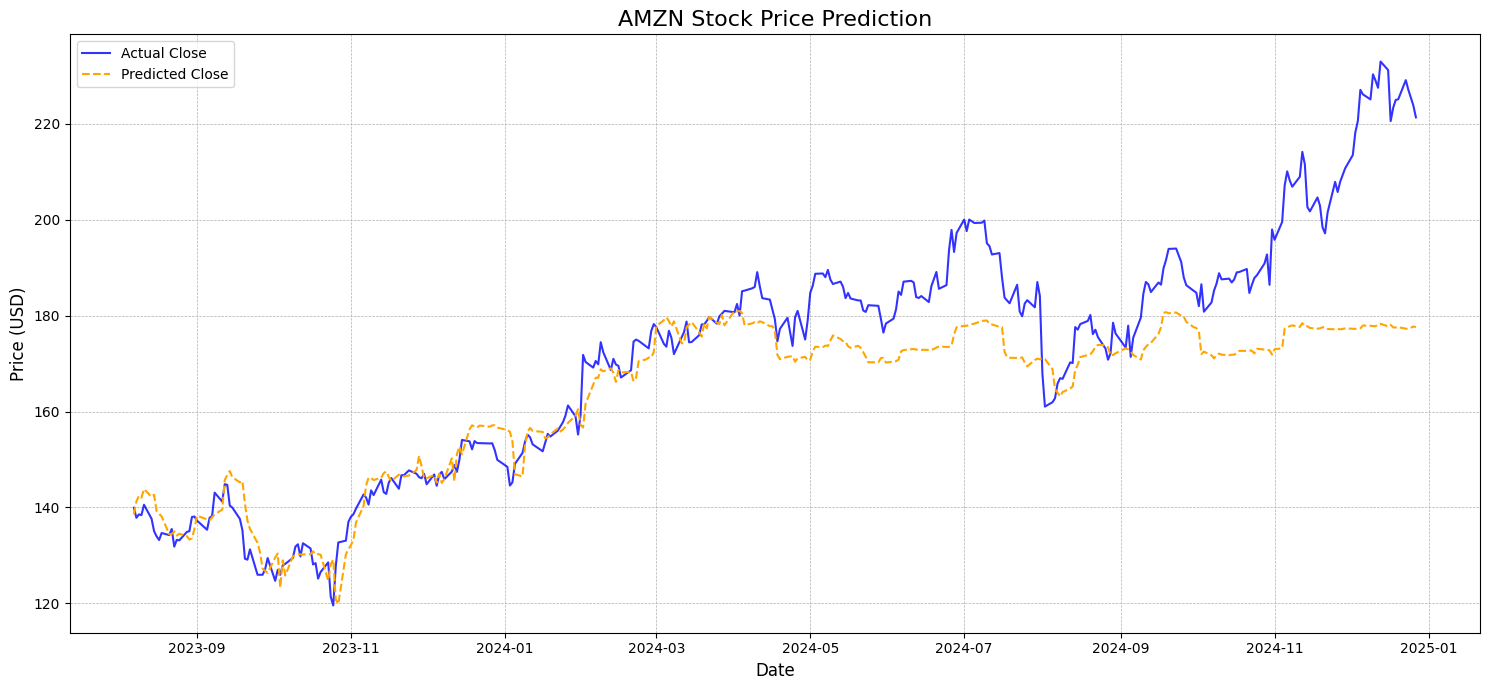

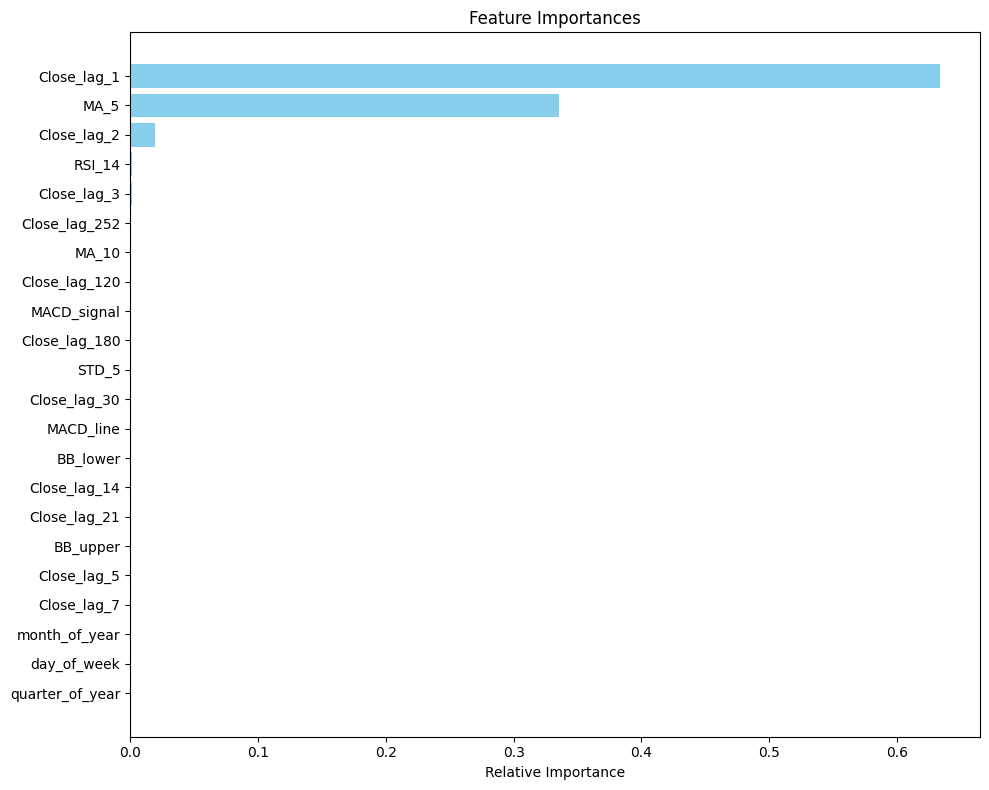

In [91]:

stock_data = fetch_data(TICKER, START_DATE, END_DATE)
featured_data = create_features(stock_data, LOOKBACK_LAGS)
model, X_test, y_test, y_pred = train_and_evaluate(featured_data)
plot_predictions(y_test, y_pred)
plot_feature_importance(model, X_test.columns)
